# Working with Data

Example of how to collect one dimensional data, which can be defined as just a collection of singularly related data:

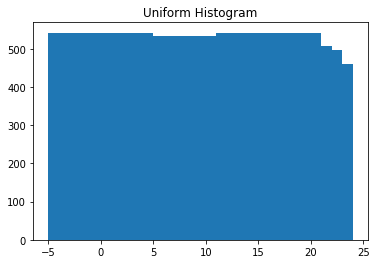

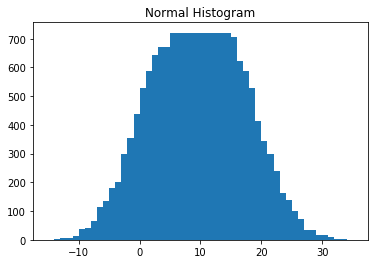

In [6]:
import math
from collections import Counter
import random
from matplotlib import pyplot as plt

def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0
    hi_z, hi_p = 10.0, 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z

def bucketize(point, bucket_size):
    return bucket_size + math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()
    
random.seed(0)
uniform = [200 * random.random() - 100 for _ in range(10000)]
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]
plot_histogram(uniform, 10, "Uniform Histogram")
plot_histogram(normal, 10, "Normal Histogram")

Here's an example of how to create a two dimensional data set, for example, years of experience and daily minutes worked:

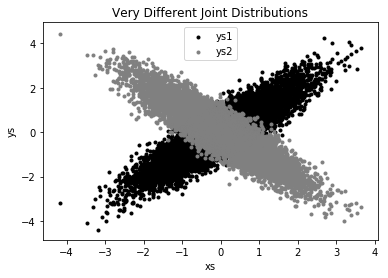

In [11]:
def random_normal():
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(10000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title('Very Different Joint Distributions')
plt.show()

You can also check the correlations to determine the difference:

In [45]:
def mean(x):
    return sum(x) / len(x)

def dot(v, w):
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    return dot(v, v)

def de_mean(x):
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    return math.sqrt(variance(x))

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0

correlation(xs, ys1), correlation(xs, ys2)

(0.8925202470926957, -0.8957220289730741)

There is also a way to create charts that demonstrate the many dimensions of your data, and the relationship they have between each other.  One way is to look at the correlation matrix, where row `i` and column `j` is the correlation between the `i`th and `j`th dimensions of data:

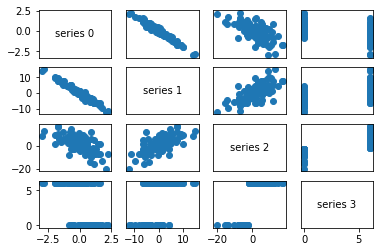

In [50]:
def get_column(A, j):
    return [A_i[j] for A_i in A]

def scatter():
    plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
    plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
    plt.xlabel('xs')
    plt.ylabel('ys')
    plt.legend(loc=9)
    plt.show()

def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)

def make_scatterplot_matrix():

    # first, generate some random data

    num_points = 100
    
    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row()
            for _ in range(num_points)]

    # then plot it

    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()

make_scatterplot_matrix()

Many times it will be necessary to munge the data:

In [30]:
def parse_row(input_row, parsers):
    return [parser(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    for row in reader:
        yield parse_row(row, parsers)

This won't work if we get an invalid type added into our data.  We'd rather pass `None` instead of a string:

In [31]:
def try_or_none(f):
    def f_or_none(x):
        try: return(x)
        except: return None
    return f_or_none

def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value for value, parser in zip(input_row, parsers)]

For example, if we have comma delimited stock prices with bad data:

```
6/20/2014,AAPL,90.91
6/20/2014,MSFT,41.68
6/20/3014,FB,64.5
6/19/2014,AAPL,91.86
6/19/2014,MSFT,n/a
6/19/2014,FB,64.34
```

we can now parse in a single step:

In [51]:
import csv
import dateutil.parser

data = []
data_to_be_munged = """
6/20/2014,AAPL,90.91
6/20/2014,MSFT,41.68
6/20/3014,FB,64.5
6/19/2014,AAPL,91.86
6/19/2014,MSFT,n/a
6/19/2014,FB,64.34
"""

reader = csv.reader(data_to_be_munged)
for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
    data.append(line)
    
for row in data:
    if any(x is None for x in row):
        print(row)

We could create a similar helper for `csv.DictReader`:

In [39]:
def try_parse_field(field_name, value, parser_dict):
    parser = parser_dict.get(field_name)
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return {field_name: try_parse_field(field_name, value, parser_dict) for field_name, value in input_dict.iteritems()}

We should also check for outliers using earlier tooling to ensure that data is both valid and concise.  When manipulating data, it's a good idea to get the general principal behind data manipulation.  Suppose we have a dictionary data set:

```python
data = [
    {
        'closing_price': 102.06,
        'date': datetime.datetime(2014, 8, 29, 0, 0),
        'symbol': 'AAPL'
    }
    #...
]
```

If we want to drill down into the data and find the highest closing price for AAPL, we would:

1. restrict ourselves to AAPL rows.
2. Grab the `closing_price` from each row.
3. Take the `max` of those prices.

Let's see this in action:

```python
max_aapl_price = max(row['closing_price'] for row in data if row['symbol'] == 'AAPL')
```

We could also get the `closing_price` for all stocks:

1. Group together all the rows with the same symbol.
2. Within each groups, do the same as before.

```python
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row['symbol']].append(row)

max_price_by_symbol = {
    symbol : max(row['closing_price'] for row in grouped_rows) for symbol, grouped_rows in by_symbol.iteritems()
}
```

And here are some generalized functions that use the same logic:

```python
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.iteritems() }

def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1
```

This allows us to rewrite our initial logic as:

```python
def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"], "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
                for yesterday, today in zip(ordered, ordered[1:])]
```

This allows us to ask more complex questions.  For example, what are the largest and smallest one-day percent changes in our data set?  Here's how we answer that question:

1. Order the prices by date.
2. Use `zip` to get pairs (previous, current)
3. Turn the pairs into new "percent change" rows.

```python
def percent_price_change(yesterday, today):
    return today['closing_price'] / yesterday['closing_price'] - 1

def day_over_day_changes(grouped_rows):
    ordered = sorted(grouped_rows, key=picker('date'))
    return [{
        'symbol': today['symbol'],
        'date': today['date'],
        'change': percent_price_change(yesterday, today)} for yesterday, today in zip(ordered, ordered[1:])
    ]
```

Then we can use this as the `value_transform` in a `group_by`:

```python
changes_by_symbol = group_by(picker('symbol'), data, day_over_day_changes)
all_changes = [change for changes in changes_by_symbol.values() for change in changes]
```

Where we can now trivially find the largest and smallest values:

```python
max(all_changes, key=picker('change'))
min(all_changes, key=picker('change'))
```

This can be used to find the month that's best to purchase tech stocks:

```python
def combine_pct_changes(pct_change1, pct_change2):
    return(1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck('change', changes))

overall_changes_by_month = group_by(lambda row: row['date'].month, all_changes, overall_change)
```

Some techniques are sensitive to the scale of the data set.  Let's consider this data set:

|person|height(in)|height(cm)|weight(lb)|
|------|:--------:|:--------:|:--------:|
|A     |63        |160       |150       |
|B     |67        |170.2     |160       |
|C     |70        |177.8     |171       |

Let's find the nearest neighbor of B:

In [55]:
def sum_of_squares(v):
    return sum(v_i ** 2 for v_i in v)

def vector_subtract(v, w):
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
    return math.sqrt(squared_distance(v, w))

a_to_b = distance([63, 150], [67, 160])
print("A:B = {0}".format(a_to_b))
a_to_c = distance([63, 150], [70, 171])
print("A:C = {0}".format(a_to_c))
b_to_c = distance([67, 160], [70, 171])
print("B:C = {0}".format(b_to_c))
min(a_to_b, a_to_c, b_to_c)

A:B = 10.770329614269007
A:C = 22.135943621178654
B:C = 11.40175425099138


10.770329614269007

The result shows that the nearest neighbor to B would be A.  However, if we measure the height in cm, we get a different answer:

In [56]:
a_to_b = distance([160, 150], [172.2, 160])
print("A:B = {0}".format(a_to_b))
a_to_c = distance([160, 150], [177.8, 171])
print("A:C = {0}".format(a_to_c))
b_to_c = distance([170.2, 160], [177.8, 171])
print("B:C = {0}".format(b_to_c))
min(a_to_b, a_to_c, b_to_c)

A:B = 15.774663229368787
A:C = 27.52889391167034
B:C = 13.370115930686627


13.370115930686627

So the nearest neighbor to B is now C.  Since changing units can change the relationships between people, it's important to rescale the data by converting the data from units of measurement to standard deviations from the mean:

In [58]:
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    ignores columns with no deviation"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j): 
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

Sometimes the actual dimensions of a data set may not correspond to the dimensions that we have.  Consider this data set:

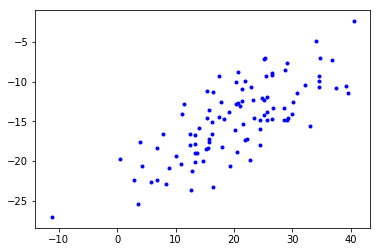

In [62]:
X = [
    [20.9666776351559,-13.1138080189357],
    [22.7719907680008,-19.8890894944696],
    [25.6687103160153,-11.9956004517219],
    [18.0019794950564,-18.1989191165133],
    [21.3967402102156,-10.8893126308196],
    [0.443696899177716,-19.7221132386308],
    [29.9198322142127,-14.0958668502427],
    [19.0805843080126,-13.7888747608312],
    [16.4685063521314,-11.2612927034291],
    [21.4597664701884,-12.4740034586705],
    [3.87655283720532,-17.575162461771],
    [34.5713920556787,-10.705185165378],
    [13.3732115747722,-16.7270274494424],
    [20.7281704141919,-8.81165591556553],
    [24.839851437942,-12.1240962157419],
    [20.3019544741252,-12.8725060780898],
    [21.9021426929599,-17.3225432396452],
    [23.2285885715486,-12.2676568419045],
    [28.5749111681851,-13.2616470619453],
    [29.2957424128701,-14.6299928678996],
    [15.2495527798625,-18.4649714274207],
    [26.5567257400476,-9.19794350561966],
    [30.1934232346361,-12.6272709845971],
    [36.8267446011057,-7.25409849336718],
    [32.157416823084,-10.4729534347553],
    [5.85964365291694,-22.6573731626132],
    [25.7426190674693,-14.8055803854566],
    [16.237602636139,-16.5920595763719],
    [14.7408608850568,-20.0537715298403],
    [6.85907008242544,-18.3965586884781],
    [26.5918329233128,-8.92664811750842],
    [-11.2216019958228,-27.0519081982856],
    [8.93593745011035,-20.8261235122575],
    [24.4481258671796,-18.0324012215159],
    [2.82048515404903,-22.4208457598703],
    [30.8803004755948,-11.455358009593],
    [15.4586738236098,-11.1242825084309],
    [28.5332537090494,-14.7898744423126],
    [40.4830293441052,-2.41946428697183],
    [15.7563759125684,-13.5771266003795],
    [19.3635588851727,-20.6224770470434],
    [13.4212840786467,-19.0238227375766],
    [7.77570680426702,-16.6385739839089],
    [21.4865983854408,-15.290799330002],
    [12.6392705930724,-23.6433305964301],
    [12.4746151388128,-17.9720169566614],
    [23.4572410437998,-14.602080545086],
    [13.6878189833565,-18.9687408182414],
    [15.4077465943441,-14.5352487124086],
    [20.3356581548895,-10.0883159703702],
    [20.7093833689359,-12.6939091236766],
    [11.1032293684441,-14.1383848928755],
    [17.5048321498308,-9.2338593361801],
    [16.3303688220188,-15.1054735529158],
    [26.6929062710726,-13.306030567991],
    [34.4985678099711,-9.86199941278607],
    [39.1374291499406,-10.5621430853401],
    [21.9088956482146,-9.95198845621849],
    [22.2367457578087,-17.2200123442707],
    [10.0032784145577,-19.3557700653426],
    [14.045833906665,-15.871937521131],
    [15.5640911917607,-18.3396956121887],
    [24.4771926581586,-14.8715313479137],
    [26.533415556629,-14.693883922494],
    [12.8722580202544,-21.2750596021509],
    [24.4768291376862,-15.9592080959207],
    [18.2230748567433,-14.6541444069985],
    [4.1902148367447,-20.6144032528762],
    [12.4332594022086,-16.6079789231489],
    [20.5483758651873,-18.8512560786321],
    [17.8180560451358,-12.5451990696752],
    [11.0071081078049,-20.3938092335862],
    [8.30560561422449,-22.9503944138682],
    [33.9857852657284,-4.8371294974382],
    [17.4376502239652,-14.5095976075022],
    [29.0379635148943,-14.8461553663227],
    [29.1344666599319,-7.70862921632672],
    [32.9730697624544,-15.5839178785654],
    [13.4211493998212,-20.150199857584],
    [11.380538260355,-12.8619410359766],
    [28.672631499186,-8.51866271785711],
    [16.4296061111902,-23.3326051279759],
    [25.7168371582585,-13.8899296143829],
    [13.3185154732595,-17.8959160024249],
    [3.60832478605376,-25.4023343597712],
    [39.5445949652652,-11.466377647931],
    [25.1693484426101,-12.2752652925707],
    [25.2884257196471,-7.06710309184533],
    [6.77665715793125,-22.3947299635571],
    [20.1844223778907,-16.0427471125407],
    [25.5506805272535,-9.33856532270204],
    [25.1495682602477,-7.17350567090738],
    [15.6978431006492,-17.5979197162642],
    [37.42780451491,-10.843637288504],
    [22.974620174842,-10.6171162611686],
    [34.6327117468934,-9.26182440487384],
    [34.7042513789061,-6.9630753351114],
    [15.6563953929008,-17.2196961218915],
    [25.2049825789225,-14.1592086208169]
]

for row in X:
    plt.scatter(row[0], row[1], marker='.', color='blue', label='Data with the wrong axes')

plt.show()

Let's create some functions that allow us to correct the axes:

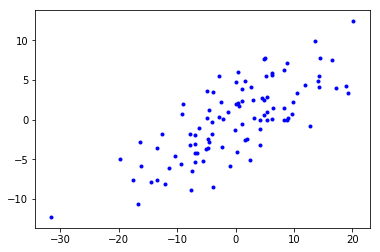

In [95]:
def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
for i in range(num_rows)]

def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean
    value of its column. the resulting matrix has mean 0 in every column"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

for row in de_mean_matrix(X):
    plt.scatter(row[0], row[1], marker='.', color='blue', label='Data with the wrong axes')

plt.show()

The next question would be which direction captures the greatest variance, which can be calculated as:

In [64]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

And given a nonzero vector `w`, we can calculate variance set in the direction determined by `w`:

In [65]:
def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction w"""
    return dot(x_i, direction(w)) ** 2
    
def directional_variance(X, w):
    """the variance of the data in the direction w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

Now we can calculate the direction by using gradient descent:

In [67]:
def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

The first principal component is the direction that maximizes the `directional_varance` function:

In [101]:
import math
from functools import partial, reduce

def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def vector_add(v, w):
    """adds two vectors componentwise"""
    return [v_i + w_i for v_i, w_i in zip(v,w)]

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    return reduce(vector_add, vectors)

def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """compute the vector whose i-th element is the mean of the
    i-th elements of the input vectors"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)   

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
tolerance)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
    return direction(unscaled_maximizer)

principal_component_values = first_principal_component(de_mean_matrix(X))
principal_component_values

[0.9238554090431896, 0.382741666377781]

And we can also use stochastic gradient descent to calculate the first principal component:

*note: this calculation is far more intensive and will take longer.*

In [91]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0)

def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

first_principal_component_sgd(de_mean_matrix(X))

[0.923910033514946, 0.3826097881267695]

Once we find the direction of the principal component, we can project our data onto it to find the values of that component:

In [107]:
def project(v, w):
    """return the projection of v onto w"""
    coefficient = dot(v, w)
    return scalar_multiply(coefficient, w)

def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """for each row of X
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

Once we do our analysis, what will be left will be effectively one dimensional:

In [113]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)
        
    return components

We can then transform our data into the lower-dimensional space spanned by the components:

In [115]:
def transform_vector(v, components):
    return [dot(v, w) for w in components]
    
def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X] 